In [1]:
#!pip install --upgrade "git+https://github.com/ibis-project/ibis.git#egg=ibis_framework[bigquery]"
# In terminal
#!pip uninstall ibis ibis-framework ibis-bigquery
#!pip install --upgrade ibis ibis-framework ibis-framework[bigquery] ibis-bigquery

In [2]:
"""
KYC 311 to ESRI 

Move Preston's script.
Connect to BigQuery
Export as ESRI layer.
"""
import datetime
import ibis
import os
import pandas

from arcgis.gis import GIS
from arcgis.features import FeatureLayerCollection

from google.cloud import bigquery

#CREDENTIAL = "./gcp-credential.json"
CREDENTIAL = "../gcp-credential.json"

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'{CREDENTIAL}'

"""This way doesn't work - just use separate JSON and call it instead of putting into .env
credentials = service_account.Credentials.from_service_account_file(
    f"{CREDENTIAL}", scopes = ["https://www.googleapis.com/auth/cloud-platform"]
)
"""
client = bigquery.Client()

# Use ibis to construct SQL query
conn = ibis.bigquery.connect(
    project_id = 'ita-datalakepoc',
    dataset_id = 'redshift'
)

In [3]:
table = conn.table('public_import311')

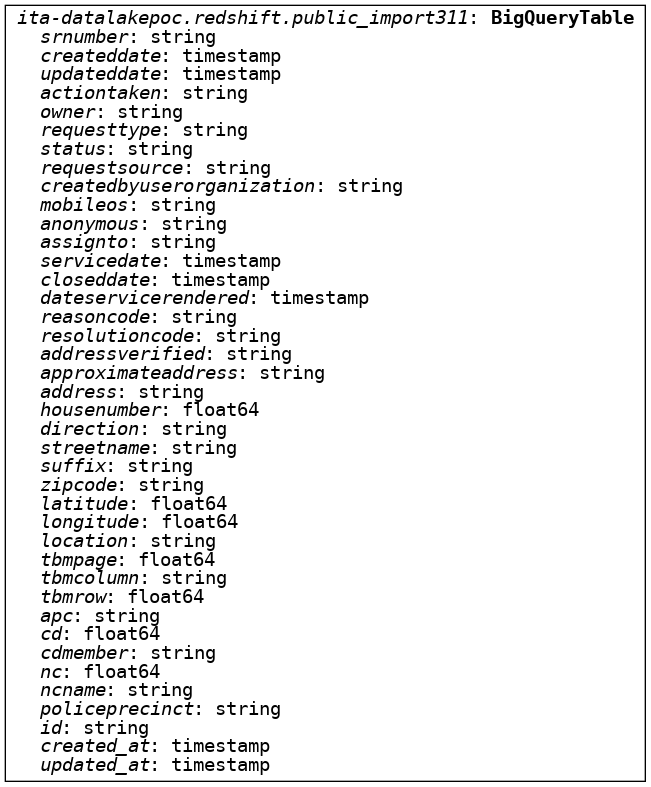

In [4]:
table

In [5]:
lahub_user = os.environ["LAHUB_ACC_USERNAME"]
lahub_pass = os.environ["LAHUB_ACC_PASSWORD"]

#myla311_layer = '3eb07324793142c4a0d991084b920349'
myla311_layer = "d8de37d58881423591087ff864388eae"
OUTPUT_FILE = "../MyLA311 Service Requests Last 6 Months.csv"

In [6]:
def prep_311_data(expr):
    # There seems to be a date issue with ibis
    # Instead of casting it as a date, let's keep date as a string
    # Parse the string instead
    # We'll keep up to the last 2 year's of data and use pandas to further subset
    current_year = datetime.datetime.today().year
    prior_year = current_year - 1
    
    # Grab the year from createddate
    expr = expr.mutate(createddate=expr.createddate.cast("string"))
    
    expr2 = expr[(expr.createddate.contains(str(current_year))) | 
                 (expr.createddate.contains(str(prior_year)))]

    # Remove specific request types
    expr3 = expr2[expr2.requesttype != "Homeless Encampment"]
    
    # Compile shows the SQL statement
    print(ibis.bigquery.compile(expr3.limit(10)))

    # Execute the query and return a pandas dataframe
    df = expr3.execute(limit=10_000) 
    
    print("Successfully executed query")
    
    return df

In [7]:
def clean_data(df, file):
    # Fix dtypes
    df = df.assign(
        createddate = pandas.to_datetime(df.createddate, errors="coerce"),
        updateddate = pandas.to_datetime(df.updateddate, errors="coerce"),
        closeddate = pandas.to_datetime(df.closeddate, errors="coerce"),
        servicedate = pandas.to_datetime(df.servicedate, errors="coerce")
    ).drop(columns = ["location"])
    
    # Subset to keep last 6 month's of data
    today_date = datetime.datetime.today()
    six_months_ago = today_date - pandas.DateOffset(months=6)    
    
    df2 = df[(df.createddate.notna()) & 
             (df.createddate >= six_months_ago)]
    
    df2.to_csv(file, index=False)
    print("Successfully exported as csv")


In [8]:
def update_geohub_layer(user, pw, layer, update_data):
    geohub = GIS('https://lahub.maps.arcgis.com', user, pw)
    flayer = geohub.content.get(layer)
    flayer_collection = FeatureLayerCollection.fromitem(flayer)
    flayer_collection.manager.overwrite(update_data)

In [9]:
if __name__ == "__main__":
    df = prep_311_data(table)
    clean_data(df, OUTPUT_FILE)
    update_geohub_layer(lahub_user, lahub_pass, myla311_layer, OUTPUT_FILE)

SELECT *
FROM (
  SELECT `srnumber`, CAST(`createddate` AS STRING) AS `createddate`,
         `updateddate`, `actiontaken`, `owner`, `requesttype`, `status`,
         `requestsource`, `createdbyuserorganization`, `mobileos`,
         `anonymous`, `assignto`, `servicedate`, `closeddate`,
         `dateservicerendered`, `reasoncode`, `resolutioncode`,
         `addressverified`, `approximateaddress`, `address`, `housenumber`,
         `direction`, `streetname`, `suffix`, `zipcode`, `latitude`,
         `longitude`, `location`, `tbmpage`, `tbmcolumn`, `tbmrow`, `apc`,
         `cd`, `cdmember`, `nc`, `ncname`, `policeprecinct`, `id`,
         `created_at`, `updated_at`
  FROM `ita-datalakepoc.redshift.public_import311`
) t0
WHERE ((STRPOS(`createddate`, '2021') - 1 >= 0) OR (STRPOS(`createddate`, '2020') - 1 >= 0)) AND
      (`requesttype` != 'Homeless Encampment')
LIMIT 10
Successfully executed query
Successfully exported as csv
